# TP 03 - Vision por Computadoras I

**Alumno**: Matias Tripode

# Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

### 1) Obtener una detección del logo en cada imagen sin falsos positivos

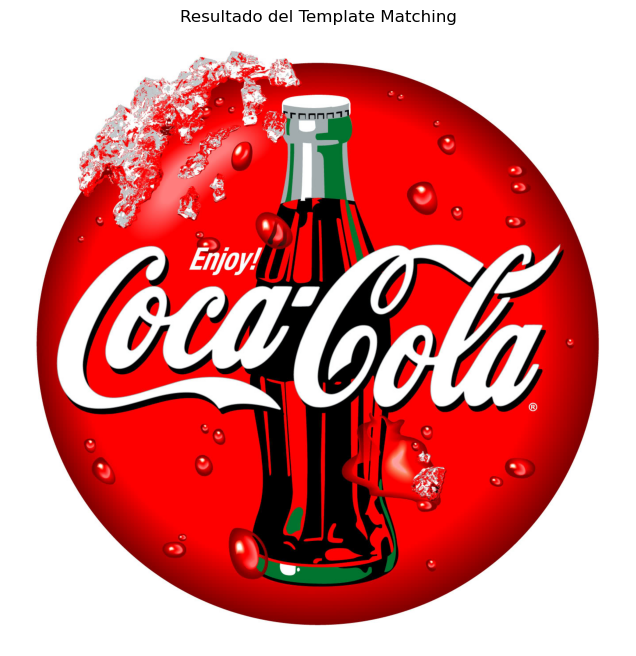

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Cargar la imagen principal y el template desde archivos locales
# Asegúrate de haber descargado las imágenes desde el repositorio a tu disco

# Rutas a los archivos
imagen_path = 'images/coca_logo_1.png'
template_path = 'template/pattern.png'

# Leer imágenes
imagen_color = cv2.imread(imagen_path)
template_color = cv2.imread(template_path)

# Verificar si las imágenes se cargaron correctamente
if imagen_color is None or template_color is None:
    raise FileNotFoundError("No se pudieron cargar las imágenes. Verifica las rutas.")

# Convertir a escala de grises
imagen_gray = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template_color, cv2.COLOR_BGR2GRAY)

# Escalamos el template para que no sea más ancho que la imagen principal
escala = min(imagen_gray.shape[1] / template_gray.shape[1],
             imagen_gray.shape[0] / template_gray.shape[0])

template_gray_resized = cv2.resize(template_gray, (0, 0), fx=escala, fy=escala)

# Obtener tamaño del template
h, w = template_gray_resized.shape

# Aplicar template matching (método de correlación normalizada)
resultado = cv2.matchTemplate(imagen_gray, template_gray_resized, cv2.TM_CCOEFF_NORMED)

# Definir umbral
umbral = 0.5

# Buscar posiciones donde la coincidencia sea mayor al umbral
loc = np.where(resultado >= umbral)

# Dibujar rectángulos en las posiciones encontradas
for pt in zip(*loc[::-1]):
    cv2.rectangle(imagen_color, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

# Mostrar el resultado
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB))
plt.title('Resultado del Template Matching')
plt.axis('off')
plt.show()
